In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from f110_gym.envs.base_classes import Integrator
from collections import Counter,defaultdict
import random
import os
import pickle
import pandas as pd
from collections import defaultdict,deque
import math
import cmath
import scipy.stats as stats
import time
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import truncnorm
from sklearn.preprocessing import normalize

In [2]:
class Reward:
    def __init__(self, min_speed=0.5, max_speed=1.8, map_centers=None):
        self.min_speed = min_speed
        self.max_speed = max_speed
        self.map_centers = map_centers
        self.initial_point = np.array([[0, 0]])

        # Total track length
        self.track_lengths = [np.linalg.norm(self.map_centers[i, :] - self.map_centers[i + 1, :]) for i in range(self.map_centers.shape[0] - 1)]
        self.total_track_length = np.sum(self.track_lengths)

        # Hyperparameters
        self.track_width = 2.2
        self.epsilon = 1e-5
        self.distance_travelled = 0
        self.distance_multiplication_factor = 50
        self.distance_scaling_factor = 1.2
        self.min_distance_from_center = 0
        self.max_distance_from_center = 1
        self.centering_reward_parameter = 0.6

        self.min_distance = self.exponential_distance(self.min_distance_from_center)
        self.max_distance = self.exponential_distance(self.max_distance_from_center)

    def reset(self, point):
        self.distance_travelled = 0
        self.initial_point = point
    
    def exponential_distance(self, distance):
        return self.distance_multiplication_factor * ((np.exp(-distance) / (2 - np.exp(-distance))) - self.centering_reward_parameter) + self.epsilon

    def progress_reward(self, curr_position, next_position):
        distance = np.linalg.norm(curr_position - next_position)
        self.distance_travelled += distance
        return self.distance_travelled / self.total_track_length

    def calculate_distance_from_center(self, curr_x, curr_y):
        distances = np.linalg.norm(self.map_centers - np.array([curr_x, curr_y]), axis=1)
        return np.argmin(distances), distances[np.argmin(distances)]

    def centering_reward(self, x, y):
        _, distance = self.calculate_distance_from_center(x, y)
        return self.distance_scaling_factor * self.exponential_distance(distance) / (self.min_distance - self.max_distance)

    def calculate_reward(self, curr_state, next_state):
        progress_reward = self.progress_reward(curr_state, next_state)
        centering_reward = self.centering_reward(next_state[0], next_state[1])
        # print(f"Distance reward: {2*progress_reward}, Centering reward: {centering_reward}")
        return progress_reward + centering_reward

In [3]:
class IndexSelector:
    def __init__(self, num_indices):
        self.num_indices = num_indices
        self.visited_indices = set()
        self.probabilities = np.ones(num_indices) / num_indices

    def select_index(self):
        if len(self.visited_indices) == self.num_indices:
            # Reset the probabilities and visited indices
            print('Visited all indices, resetting')
            self.visited_indices = set()
            self.probabilities = np.ones(self.num_indices) / self.num_indices

        # Select an index based on the current probabilities
        random_idx = np.random.choice(np.arange(self.num_indices), p=self.probabilities)

        # Update the probabilities
        self.visited_indices.add(random_idx)
        if len(self.visited_indices) < self.num_indices:
            self.probabilities[random_idx] = 0
            remaining_prob = 1 - np.sum(self.probabilities)
            self.probabilities[self.probabilities > 0] += remaining_prob / np.sum(self.probabilities > 0)

        return random_idx

In [ ]:
class F1Tenth_navigation:

    def __init__(self,gym_env_code='f110_gym:f110-v0', num_agents=1, map_path='./f1tenth_racetracks/Austin/Austin_map', map_ext='.png', sx=0., sy=0., stheta=0., map_centers_file=None, save_path=None, track_name=None, inference=None,reward_file=None,collision_file=None):

        # Environment setup
        self.env = gym.make(gym_env_code, map=map_path, map_ext=map_ext, num_agents=num_agents, timestep=0.01, integrator=Integrator.RK4)
        self.env.add_render_callback(self.render_callback)
        self.sx, self.sy, self.stheta = sx, sy, stheta
        self.save_path = save_path
        self.track_name = track_name
        self.num_agents = num_agents
        self.map_path = map_path
        self.map_ext = map_ext
        self.map_centers_file = pd.read_csv(map_centers_file)
        self.map_centers_file.columns = ['x', 'y', 'w_r', 'w_l']
        self.map_centers_file.index = self.map_centers_file.index.astype(int)
        self.map_centers = self.map_centers_file.values[:, :2]
        self.reward_file = reward_file
        self.collision_file = collision_file

        # Random Seed
        self.random_seed = 42
        np.random.seed(self.random_seed)

        # Environment Observation Parameters
        self.num_beams = 1080
        self.n_features = 12
        self.angle = 270

        # Action Space Parameters
        self.num_angles = 51
        self.num_speeds = 10

        # LiDAR downsampling parameters
        self.n_sectors = 30

        # State Space Parameters
        self.num_states = 2 ** self.n_features

        # Speed Parameters
        self.min_speed = 0.8
        self.max_speed = 2

        # Action Space
        self.angles_deg = np.linspace(-self.angle // 2, self.angle // 2, self.num_angles)[::-1]
        self.angles = self.convert_deg_to_rad(self.angles_deg)
        self.speeds = np.linspace(self.min_speed, self.max_speed, self.num_speeds)
    
        # State Space - Q-Table
        if inference is not None:
            self.weights = np.load(inference)
            self.num_collisions = int(inference.split('_')[1].split('.')[0])
            print(f'Loaded Weights')
        else:
            self.weights = np.zeros((self.num_states,self.num_angles,self.num_speeds))
            self.num_collisions = 0


        # ELigibility Trace
        self.ET_IS = np.zeros((self.num_states,self.num_angles,self.num_speeds))

        # projection matrix
        self.projection_matrix = self.generate_projection_matrix()

        # binary powers
        self.binary_powers = np.array([2 ** i for i in range(self.n_features)])

        # Training Variables
        self.curr_state = None
        self.next_state = None
    
        
        self.action_threshold_decay = 0.999997
        self.action_threshold = 0.25 * (self.action_threshold_decay ** self.num_collisions)

        # Imported Classes
        self.reward_class = Reward(min_speed=self.min_speed, max_speed=self.max_speed, map_centers=self.map_centers)
        self.index_selector = IndexSelector(self.map_centers.shape[0])      

        # Sarsa Parameters
        self.learning_rate = 0.1
        self.discount_factor = 0.95
        self.decay_rate = 0.9

        # Reward
        self.reward = 0
        self.cumulative_reward = 0
        self.episodic_rewards = [0]

        # Time
        self.collision_times = []
        

    def render_callback(self, env_renderer):
        e = env_renderer
        x = e.cars[0].vertices[::2]
        y = e.cars[0].vertices[1::2]
        top, bottom, left, right = max(y), min(y), min(x), max(x)
        e.score_label.x = left
        e.score_label.y = top - 700
        e.left = left - 800
        e.right = right + 800
        e.top = top + 800
        e.bottom = bottom - 800

    def convert_deg_to_rad(self, array):
        return array * np.pi / 180
    
    def get_statistical_properties(self,lidar_input,n_sectors=30):
        lidar_input = np.asarray(lidar_input, dtype=np.float32)
        sector_size = lidar_input.shape[0] // n_sectors
        sectors = lidar_input[:sector_size * n_sectors].reshape(n_sectors, sector_size)
        sector_features = np.vstack(
            [   np.mean(sectors, axis=1),
                np.std(sectors, axis=1),
                np.max(sectors, axis=1),
                np.min(sectors, axis=1),
                np.median(sectors, axis=1),
                np.percentile(sectors, 75, axis=1)
            ])
        return sector_features
    
    def binarize_vector(self,vector):
        minimum,maximum = vector.min(),vector.max()
        threshold = minimum + (maximum - minimum)/2
        binary_vector = np.where(vector >= threshold,1,0)
        return binary_vector
    
    def generate_projection_matrix(self):
        a = (0 - 0.5) / 0.25  
        b = (1 - 0.5) / 0.25   
        return truncnorm.rvs(a, b, loc=0.5, scale=0.25, size=(self.n_sectors, self.n_features))
    
    def get_binary_representation(self,lidar_input):
        lidar = normalize(self.get_statistical_properties(lidar_input),axis=1)
        proj = np.dot(lidar,self.projection_matrix)
        binary = self.binarize_vector(proj[0])
        return binary.reshape(1,-1)
    
    def get_state(self, binary):
        return np.dot(binary[0], self.binary_powers)
    
    def selection_action(self, state):
        random_number = np.random.rand()
        if random_number < self.action_threshold:
            angle_index = np.random.randint(0, self.num_angles)
            speed_index = np.random.randint(0, self.num_speeds)
        else:
            flattened = self.weights[state].flatten()
            max_value = np.max(flattened)
            max_indices = np.where(flattened == max_value)[0]
            max_index = np.random.choice(max_indices)
            
            angle_index, speed_index = np.unravel_index(max_index, self.weights[state].shape)

        self.action_threshold *= self.action_threshold_decay

        return angle_index, speed_index
    
    def sarsa_weight_update(self,angle_idx,speed_idx,reward):
        self.ET_IS [self.curr_state,angle_idx,speed_idx] = 1

        next_angle_idx,next_speed_idx = self.selection_action(self.next_state)
        delta = reward + self.discount_factor * self.weights[self.next_state,next_angle_idx,next_speed_idx] - self.weights[self.curr_state,angle_idx,speed_idx]

        self.weights += self.learning_rate * delta * self.ET_IS
        self.ET_IS *= self.discount_factor * self.decay_rate

        return next_angle_idx,next_speed_idx

    def save_reward_time(self):
        if not os.path.exists(os.path.join(self.save_path, self.track_name)):
            os.mkdir(os.path.join(self.save_path, self.track_name))
        
        if self.reward_file is not None:

            r = np.append(np.load(self.reward_file), self.episodic_rewards[-1])
            t = np.append(np.load(self.collision_file), self.collision_times[-1])
            np.save(os.path.join(self.save_path, self.track_name, f'rewards.npy'), np.array(r))
            np.save(os.path.join(self.save_path, self.track_name, f'times.npy'), np.array(t))
        else:
            np.save(os.path.join(self.save_path, self.track_name, f'rewards.npy'), np.array(self.episodic_rewards))
            np.save(os.path.join(self.save_path, self.track_name, f'times.npy'), np.array(self.collision_times))
    
    def save_weights(self):
        if not os.path.exists(os.path.join(self.save_path, self.track_name)):
            os.mkdir(os.path.join(self.save_path, self.track_name))
        np.save(os.path.join(self.save_path, self.track_name, f'weights_{self.num_collisions + 1}.npy'), self.weights)
        # print(f'File saved')


    def train(self):
        obs, step_reward, done, info = self.env.reset(np.array([[self.sx, self.sy, self.stheta]]))
        lidar = obs['scans'][0]
        down_sampled = self.get_binary_representation(lidar)
        self.curr_state = self.get_state(down_sampled)
        self.reward_class.reset(np.array([[self.sx, self.sy]]))
        angle_index,speed_index = self.selection_action(self.curr_state)
        start_time = time.time()
        while True:
            steering_angle,speed = self.angles[angle_index],self.speeds[speed_index]
            curr_x = obs['poses_x'][0]
            curr_y = obs['poses_y'][0]
            obs, reward, done, info = self.env.step(np.array([[steering_angle, speed]]))
            lidar = obs['scans'][0]
            down_sampled = self.get_binary_representation(lidar)
            self.next_state = self.get_state(down_sampled)

            if done:
                self.reward = -100
            else:
                self.reward = self.reward_class.calculate_reward(np.array([curr_x, curr_y]), np.array([obs['poses_x'][0], obs['poses_y'][0]]))

            # print(f'Reward: {self.reward},Curr_state is {self.curr_state},steering angle: {steering_angle}, speed: {speed}')
            self.cumulative_reward += self.reward

            angle_index,speed_index = self.sarsa_weight_update(angle_index,speed_index,self.reward)
            self.curr_state = self.next_state

            # Randomize the starting point after collision
            if done:
                self.num_collisions += 1

                # Obtaining a new random position on the track
                random_idx = self.index_selector.select_index()
                n_x, n_y = self.map_centers[random_idx]
                delta_x, delta_y = np.random.uniform(-0.75, 0.75), np.random.uniform(-0.2, 0.2)
                n_theta = np.random.choice(self.angles)

                # Sensing the new state
                obs, step_reward, done, info = self.env.reset(np.array([[n_x + delta_x, n_y + delta_y, n_theta]]))
                lidar = obs['scans'][0]
                down_sampled = self.get_binary_representation(lidar)
                self.curr_state = self.get_state(down_sampled)
                angle_index,speed_index = self.selection_action(self.curr_state)

                # Resetting 
                self.reward_class.reset(np.array([[n_x + delta_x, n_y + delta_y]]))
                self.ET_IS.fill(0)

                # Checkpoint
                if (self.num_collisions + 1) % 100 == 0:
                    end_time = time.time()
                    print(f'Collision: {self.num_collisions+1}, Time: {end_time - start_time}, Reward: {self.cumulative_reward - self.episodic_rewards[-1]}')
                    self.collision_times.append(end_time - start_time)
                    self.episodic_rewards.append(self.cumulative_reward - self.episodic_rewards[-1])
                    self.save_reward_time()
                    start_time = end_time
                    self.save_weights()

                # if (self.num_collisions+1) % 5000 == 0:
                #     self.save_weights()

            # self.env.render(mode='human')
    
    def inference(self):
        obs, step_reward, done, info = self.env.reset(np.array([[self.sx, self.sy, self.stheta]]))
        lidar = obs['scans'][0]
        down_sampled = self.get_binary_representation(lidar)
        self.curr_state = self.get_state(down_sampled)
        self.reward_class.reset(np.array([[self.sx, self.sy]]))
        angle_index,speed_index = self.selection_action(self.curr_state)
        while not done:
            steering_angle,speed = self.angles[angle_index],self.speeds[speed_index]
            obs, reward, done, info = self.env.step(np.array([[steering_angle, speed]]))
            lidar = obs['scans'][0]
            down_sampled = self.get_binary_representation(lidar)
            self.next_state = self.get_state(down_sampled)
            angle_index,speed_index = self.selection_action(self.next_state)
            self.curr_state = self.next_state
            
            self.env.render(mode='human')

In [5]:
path = './f1tenth_racetracks'
all_map_paths=[]
map_centers = []
map_names = []
track_lengths=[]
for folder in os.listdir(path):
    if folder not in ['README.md','.gitignore','convert.py','LICENSE','rename.py','.git']:
        folder_name=folder
        file_name=folder_name.replace(' ','')+'_map'
        map_center = folder_name.replace(' ','')+'_centerline.csv'
        track_lengths.append(len(pd.read_csv(f'{path}/{folder_name}/{map_center}')))
        map_names.append(folder_name)
        all_map_paths.append(f'{path}/{folder_name}/{file_name}')
        map_centers.append(f'{path}/{folder_name}/{map_center}')

list(zip(map_names,track_lengths))

[('Melbourne', 1060),
 ('Spielberg', 864),
 ('Catalunya', 931),
 ('Zandvoort', 864),
 ('MoscowRaceway', 813),
 ('Austin', 1102),
 ('Mexico City', 860),
 ('Monza', 1159),
 ('Hockenheim', 914),
 ('Spa', 1401),
 ('SaoPaulo', 862),
 ('YasMarina', 1110),
 ('BrandsHatch', 781),
 ('Shanghai', 1090),
 ('Nuerburgring', 1029),
 ('Sakhir', 1082),
 ('Oschersleben', 739),
 ('IMS', 805),
 ('Sepang', 1108),
 ('Budapest', 876),
 ('Sochi', 1169),
 ('Silverstone', 1178),
 ('Montreal', 872)]

In [6]:
global num_agents,map_path,map_ext,sx,sy,stheta
num_agents = 1
map_ext = '.png'
sx = 0.
sy = 0.
stheta = 1.0
map_index = 0
map_path = all_map_paths[map_index]
map_center = map_centers[map_index]
map_name = map_names[map_index]
save_path = './Weights/'
# inference_file = None
inference_file = f'./Weights/{map_name}/weights_15500.npy'
reward_file = f'./Weights/{map_name}/rewards.npy'
collision_file = f'./Weights/{map_name}/times.npy'
simulator = F1Tenth_navigation(num_agents=num_agents,map_path=map_path,map_ext=map_ext,sx=sx,sy=sy,stheta=stheta,map_centers_file=map_center,save_path=save_path,track_name=map_name,inference=inference_file,reward_file=reward_file,collision_file=collision_file)
simulator.train()
# simulator.inference()

/f1tenth_gym/gym/f110_gym/envs/base_classes.py:93: UserWarning: Chosen integrator is RK4. This is different from previous versions of the gym.
  warnings.warn(f"Chosen integrator is RK4. This is different from previous versions of the gym.")


Loaded Weights
Collision: 15750, Time: 1273.576001405716, Reward: 28250.328962915508
Collision: 16000, Time: 1040.4004147052765, Reward: 11679.397115175718
Collision: 16250, Time: 1517.176308631897, Reward: 75238.75766031792
Collision: 16500, Time: 690.4146616458893, Reward: -3637.6688910434896
Visited all indices, resetting
Collision: 16750, Time: 779.9555969238281, Reward: 69478.65846670054
Collision: 17000, Time: 1214.9679245948792, Reward: 26323.120400694184
Collision: 17250, Time: 1580.4597208499908, Reward: 135371.11196094158
Collision: 17500, Time: 5498.85583281517, Reward: 850165.7135374997


KeyboardInterrupt: 

np.save(f'{save_path}{map_name}/weights_17500.npy',simulator.weights)

In [29]:
r_path = '/workspaces/f1_tenth/Weights/Melbourne/rewards.npy'
t_path = '/workspaces/f1_tenth/Weights/Melbourne/times.npy'
# 23b2e5d474d4f00d1c5af7f634a14209a74f0d69

In [40]:
r = np.load(r_path)
r.shape,r

((28,),
 array([      0.        , -115248.87833917,  -85135.43007456,
        -124206.22959715,   73387.60776476,  -43780.93123158,
         -45120.20336094,  -99757.73543359,   -2521.38527203,
         -72185.42169025,  -18242.18385293,    4422.3336631 ,
         -54151.51850325,   72895.81219267,  -35126.68334495,
         -41645.74837891,  -82470.83082186,  -99852.28966159,
        -106030.66181396,  383973.70019043,   28250.32896292,
          11679.39711518,   75238.75766032,   -3637.66889104,
          69478.6584667 ,   26323.12040069,  135371.11196094,
         850165.7135375 ]))

In [31]:
reward_set=  set()
new_rewards = []
for i in range(0,len(r)):
    if r[i] not in reward_set:
        new_rewards.append(r[i])
        reward_set.add(r[i])

In [33]:
np.save('/workspaces/f1_tenth/Weights/Melbourne/rewards.npy',np.array(new_rewards))

In [39]:
t= np.load(t_path)
t.shape,t

((30,),
 array([1214.89850998, 2044.81393099, 2792.63542533, 4743.1211071 ,
         969.57054329,  960.03930712,  894.94210672,  962.77982616,
         956.98172593,  867.52583623, 2060.55318642, 1805.92929554,
        1400.17881918, 2621.48857522, 1168.68393993, 2318.42638946,
        1225.35464692, 1044.23712873,  831.36393619,  660.48105717,
        1507.57367516, 5050.75190306, 1273.57600141, 1040.40041471,
        1517.17630863,  690.41466165,  779.95559692, 1214.96792459,
        1580.45972085, 5498.85583282]))

In [35]:
time_set=  set()
new_times = []
for i in range(0,len(t)):
    if t[i] not in time_set:
        new_times.append(t[i])
        time_set.add(t[i])

In [37]:
len(new_times)

30

In [38]:
np.save('/workspaces/f1_tenth/Weights/Melbourne/times.npy',np.array(new_times))

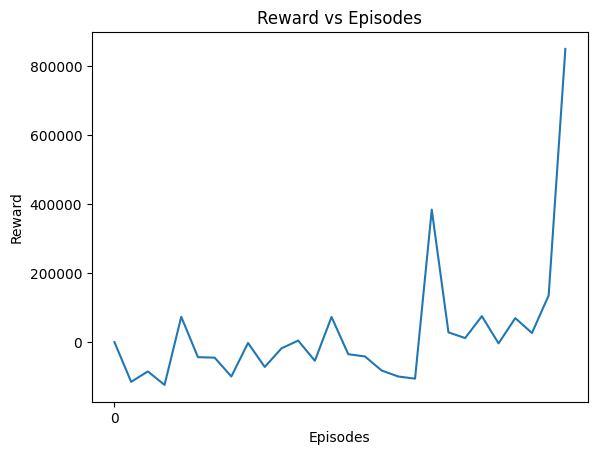

In [47]:
plt.plot(new_rewards)
plt.xlabel('Episodes')
plt.xticks(np.arange(0, len(new_rewards), step=1000))
plt.ylabel('Reward')
plt.title('Reward vs Episodes')
plt.show()

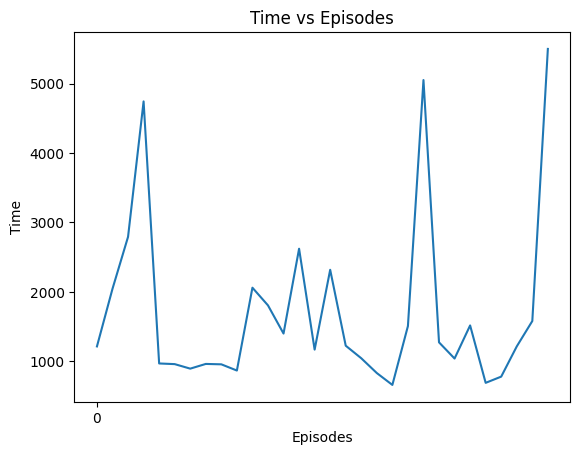

In [48]:
plt.plot(new_times)
plt.xlabel('Episodes')
plt.xticks(np.arange(0, len(new_times), step=1000))
plt.ylabel('Time')
plt.title('Time vs Episodes')
plt.show()